In [15]:
# Important imports
import gradio as gr
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import faiss
from tensorflow.python.ops.numpy_ops import np_config 
np_config.enable_numpy_behavior()

# Importing training and testing data
from emnist import extract_training_samples
from emnist import extract_test_samples

# scikit-learn performance metric utilities (credit to Rachel)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [6]:
# Faiss implementation speeds up knn fit and predict
# source: https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [9]:
# Import training and testing data (using the balanced dataset of emnist)
training_images, training_labels = extract_training_samples('balanced')
testing_images, testing_labels = extract_test_samples('balanced')

# Take a subset of the first n-elements of training data
training_data_size = 100000
training_x = np.zeros((training_data_size,training_images.shape[1]**2),dtype=int)
training_y = np.zeros((training_data_size,),dtype=int)

# Take a subset of the first n-elements of testing data (all of the testing data)
testing_data_size = testing_images.shape[0]
testing_x = np.zeros((testing_data_size, testing_images.shape[1]**2),dtype=int)
testing_y = np.zeros((testing_data_size,),dtype=int)

for i in range(training_data_size):
  training_x[i] = training_images[i].flatten()
  training_y[i] = training_labels[i]
  
for i in range(testing_data_size):
  testing_x[i] = testing_images[i].flatten()
  testing_y[i] = testing_labels[i]

In [10]:
# Create and fit training data to a knn with 2 neighbors
num_neighbors = 2
knn = FaissKNeighbors(num_neighbors)
knn.fit(training_x, training_y)

In [11]:
# Output the accuracy of knn on the training and testing datasets
training_pred = knn.predict(training_x)
testing_pred = knn.predict(testing_x)

print("Training Accuracy is ", accuracy_score(training_y, training_pred)*100)
print("Validation Accuracy is ", accuracy_score(testing_y, testing_pred)*100)

Training Accuracy is  88.302
Validation Accuracy is  75.77127659574468


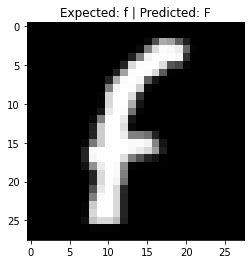

In [40]:
# Letters in the correct order so that they can be indexed using the labels (credit to Allison)
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

# Displays the ith image, expected, and predicted
def display_prediction(image, expected, predicted):
    plt.imshow(image, cmap="gray") 
    plt.title("Expected: " + str(expected) + " | Predicted: " + str(predicted))
    plt.show()

# Chooses a random data point
idx = randint(0, testing_y.shape[0]-1)

# Displays training model at idx
training_image = training_x[idx].reshape(28,28)
training_expected = class_mapping[training_y[idx]]
training_predicted = class_mapping[training_pred[idx]]
display_prediction(training_image, training_expected, training_predicted)

# Displays testing model at idx
testing_image = testing_x[idx].reshape(28,28)
testing_expected = class_mapping[testing_y[idx]]
testing_predicted = class_mapping[testing_pred[idx]]
display_prediction(testing_image, testing_expected, testing_predicted)

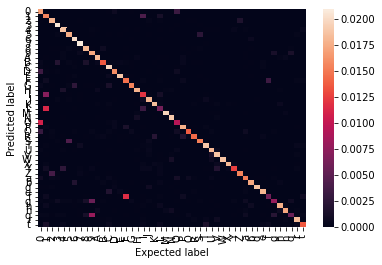

In [16]:
# Convert all labels in an array to their corresponding digit/lowercase letter (credit to Rachel)
def get_class_labels(labels):
    class_labels = np.chararray(labels.shape)
    for i, ele in enumerate(labels):
        class_labels[i] = class_mapping[int(ele)]
    return class_labels

# Generate confusion matrix of the testing data (credit to Rachel)
matrix = confusion_matrix(get_class_labels(testing_y), get_class_labels(testing_pred))

# Displays confusion matrix with expected label on the x-axis and the predicted label on the y-axis (credit to Rachel)
sns.heatmap(matrix/np.sum(matrix), xticklabels=list(class_mapping), yticklabels=list(class_mapping))
plt.xlabel('Expected label')
plt.ylabel('Predicted label')

In [17]:
# Function to classify an input image for gradio output
def image_classifier(image):
    pred = knn.predict(np.reshape(image, (1, 784)))
    return str(class_mapping[int(pred[0])])

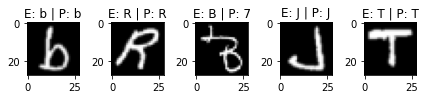

In [32]:
# Randomly classifies 5 images to display (note E = Expected, P = Predicted)
for i in range(5):
    idx = randint(0, testing_x.shape[0]-1)
    plt.subplot(1, 5, i + 1)
    plt.title("E: " + str(class_mapping[testing_y[idx]]) + " | P: " + str(image_classifier(testing_images[idx])))
    plt.imshow(testing_images[idx], cmap="gray")
plt.tight_layout()
plt.show()

In [38]:
# sketchpad to draw on -> image
image = gr.inputs.Image(shape=(28, 28), image_mode="L", invert_colors=True, source="canvas", type="numpy")
# Gradio interface
iface = gr.Interface(fn=image_classifier, inputs=image, outputs="label").launch(share="True")

Running on local URL:  http://127.0.0.1:7870/
Running on public URL: https://51641.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app
